In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

%reload_ext autoreload
%autoreload 2

# set plot properties to seaborn globally
plt.style.use("seaborn-v0_8-white")

----
### Further Pre-Processing and Feature Engineering: `loan_data_clean_and_imputed_20(07-14).csv`
-----

In [2]:
processed_data_dir = "processed_data/"

loan_df = pd.read_csv(processed_data_dir + 'loan_data_clean_and_imputed_20(07-14).csv')

loan_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,...,term_in_months,earliest_cr_line_dt,issue_d_dt,total_rev_hi_lim_missing,missing_credit_line,tot_coll_amt_missing,tot_cur_bal_missing,delinquency_missing,record_missing,major_derog_missing
0,5000,5000,4975.0,10.65,162.87,B,B2,RENT,24000.0,Verified,...,36,1985-01-01,2011-12-01,1,0,1,1,1,1,1
1,2500,2500,2500.0,15.27,59.83,C,C4,RENT,30000.0,Source Verified,...,60,1999-04-01,2011-12-01,1,0,1,1,1,1,1
2,2400,2400,2400.0,15.96,84.33,C,C5,RENT,12252.0,Not Verified,...,36,2001-11-01,2011-12-01,1,0,1,1,1,1,1
3,10000,10000,10000.0,13.49,339.31,C,C1,RENT,49200.0,Source Verified,...,36,1996-02-01,2011-12-01,1,0,1,1,0,1,1
4,3000,3000,3000.0,12.69,67.79,B,B5,RENT,80000.0,Source Verified,...,60,1996-01-01,2011-12-01,1,0,1,1,0,1,1


In [3]:
## importing the description of the attributes as a dictionary

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

raw_data_dir = "raw_data/"

xls = pd.ExcelFile(raw_data_dir + 'LCDataDictionary.xlsx')
#print(xls.sheet_names)  #to see available sheets

# descriptions of the data columns are in the 'LoanStats' sheet
loan_data_desc = xls.parse('LoanStats')

# drop unnecessary rows that does not have a description in the description df
loan_data_desc.dropna(inplace = True)

# replace a weird looking one: total_rev_hi_lim \xa0
loan_data_desc.LoanStatNew = loan_data_desc.LoanStatNew.str.replace(r'\s+', '', regex=True)

# turn into a simple dictionary for easy access to column descriptions
col_desc_dict = loan_data_desc.set_index('LoanStatNew')['Description'].to_dict()

In [4]:
loan_df.issue_d_dt.min(), loan_df.issue_d_dt.max()

('2007-06-01', '2014-12-01')

In [5]:
loan_df.earliest_cr_line_dt.min(), loan_df.earliest_cr_line_dt.max()

('1944-01-01', '2011-11-01')

We have `earliest_cr_line_dt` and `issue_d_dt` datetime (dt) variables we created. As expected the issue date of the loan varies between June 2007 until December 2014 while the earliest credit line opening date goes back much longer. The time it passed since the earliest credit line opening might be used as an indicator for credit worthiness of the borrowers. The longer they are around the better. 

We can thus generate a variable from the time difference of `earliest_cr_line_dt` and `issue_d_dt` in months. 

In [6]:
# first parse object type dates as datetime
loan_df.loc[:,'earliest_cr_line_dt'] = pd.to_datetime(loan_df.earliest_cr_line_dt)
loan_df.loc[:,'issue_d_dt'] = pd.to_datetime(loan_df.issue_d_dt)

loan_df['mths_since_earliest_cr_line'] = round((loan_df.issue_d_dt - loan_df.earliest_cr_line_dt) / np.timedelta64(30, 'D'))

In [7]:
# drop the original dates
loan_df = loan_df.drop(columns=['earliest_cr_line_dt', 'issue_d_dt'])

- Setting the target variable by pre-processing `loan_status`: 

In [8]:
loan_df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

**Grace period definition**: A grace period is a specified time after a payment due date during which you can make a payment without incurring late fees, penalties, or service interruptions. 

Therefore, instances with `Fully Paid`, `Current` and `In Grace Period`, `Late (16-30 days)`, `Does not meet the credit policy. Status:Fully Paid` will correspond to non-default accounts while `Charged_off` and `Default`, `Late (31-120 days)` and `Does not meet the credit policy. Status:Charged Off` instances will be certainly in the defaulted category.

In [9]:
# percentages of account status 

(loan_df.loan_status.value_counts()/loan_df.loan_status.count()) * 100

loan_status
Current                                                48.087757
Fully Paid                                             39.619332
Charged Off                                             9.109236
Late (31-120 days)                                      1.479782
In Grace Period                                         0.674695
Does not meet the credit policy. Status:Fully Paid      0.426349
Late (16-30 days)                                       0.261214
Default                                                 0.178432
Does not meet the credit policy. Status:Charged Off     0.163205
Name: count, dtype: float64

In [10]:
# We assing good loans 1, and defaulted ones 0 

loan_df['loan_status'] = np.where(loan_df.loan_status.isin(['Charged Off','Late (31-120 days)', 
                                                                             'Default', 'Does not meet the credit policy. Status:Charged Off']),0,1)

(loan_df.loan_status.value_counts() / loan_df.loan_status.count())

loan_status
1    0.890693
0    0.109307
Name: count, dtype: float64

We have about 11 percent default class while 89 percent good borrowers!

- Next we generate a dummies data-frame from the categorical attributes in the loan data. PD models are required to be interpretable, and this is a common approach in the industry. In fact, we will also need to turn our continuous variables into categories as well. 
- In the end, the goal is to encode these categories with dummy variables. Note that for a variable with $k$ categories, we can actually encapsulate the information with $k-1$ number of dummy variables by picking a baseline/reference category. This is done to avoid multi-collinearity in the dummy variables. 

#### Splitting the data into train and validation sets
-----

Before we assess the strength of the predictors in explaining the good or bad credits. We split the cleaned and imputed data into a training set with which we will train a classifier and a validation set that we will use to validate the model.

In [11]:
from sklearn.model_selection import train_test_split

# 80 percent to 20 percent split 
loan_Xt, loan_Xval, loan_yt, loan_yval = train_test_split(loan_df.drop(columns = 'loan_status'), loan_df.loan_status, random_state = 42, test_size=0.2)

In [12]:
# suffling leads to suffled indices, we reset them so that it starts from 0 and goes up onwards

loan_Xt.reset_index(drop=True, inplace = True)
loan_Xval.reset_index(drop=True, inplace = True)
loan_yt.reset_index(drop=True, inplace = True)
loan_yval.reset_index(drop=True, inplace = True)

----
### Assessing explanatory power of an independent variable 
-----

To make informed decisions about which predictors to keep in our model, it is important to mention two important metrics: 

- Weight of Evidence (`WoE`): To what extent an independent variable would predict a target! For each predictor category $i$, it is given the log of the ratio's of the percentage of the target classes for that categorical independent variable: 

$$

\textrm{WoE}_{i} = \ln \left(\frac{\% (y = 1)_i}{\% (y = 0)_i}\right)

$$

where $i$ denotes different categories for the independent/predictor variable. Note that the further away `WoE` from zero in absolute value, the better for the discriminatory power of the independent variable in differentiation classes of the dependent variable. This makes sense, as if the ratio inside the logarithm is one, implying that there is an equal amount for the dependent variable class corresponding to that category of the independent variable, there is zero weight of evidence for the independent variable to explain the dependent one! 

In summary, `WoE` gives us an insight into how useful a given category of an independent variable is, with respect to predicting a target!

- Of course, such a `WoE` analysis would be redundant if the original categorical variable was useless to begin with. In order to assess the overall usefulness of a categorical variable, we use **Information Value**. Suppose we split an independent variable into $k$ categories (using e.g fine/course classing), we can then compute the `WoE` of each category and weigh it by the difference of the proportion of classes of the dependent variable that occur for each of those categories. This gives us **Information Value** (`IV`): 

$$
\textrm{IV} = \sum_{i = 1}^{k} \left[\%(y = 1) - \% (y = 0)\right]_i \times \textrm{WoE}_i.
$$

Since we sum over all the categories of the original predictor, IV is a measure of how much information the original independent variable brings to explain the dependent variable. Therefore, we can use IV for **pre-selection** of features for the PD model. 
 
`IV` $\in [0,1]$ and we have the following ranges to judge the effectiveness of a categorical variable explaining the target: 

- `IV` < 0.02 ---> no predictive power
- 0.02 < `IV` < 0.1 ----> Weak predictive power
- 0.1 < `IV` < 0.3 ----> Medium predictive power
-  0.3 < `IV` < 0.5 ----> Strong predictive power
-  0.5 < `IV` ----> Suspiciously high predictive power, too good to be true. 
 


We will define a custom helper function `compute_woe_iv()` from `feature_utils.py` that will count the proportion of values for different categories of a categorical variable that will return the `WoE` of each category and the corresponding total `IV` of the categorical variable. This function can work both with discrete categorical and continuous variables that are binned through fine (equal spread binning) / course binning methods. 

We will then check the results with the `optbinning` library which uses optimization methods to pick the right bins for the categories of both discrete / continuous variables. 

Note that in the analysis below, we intend to use `IV` as a guide for the **uni-variate** predictive power, in particular as a rule of thumb heuristic analysis. In our context, it would silly to for example discard a variable with IV = 0.019 but to keep another with IV = 0.021 as there is no solid statistical ground that makes the former irrelevant while making the latter marginally useful. For example, variables with low IV can be powerful when considered in interaction terms. Furthermore, some variables with low IV might have strategic or regulatory value, e.g for ML explainability. Finally, as the formula suggest `IV`is sensitive to the binning, sample size or its distribution. 

In summary, we would not like to treat `IV ` = 0.02 as a hard cut-off in determining the usefulness of a variable. On the other hand, if a variable has a too low `IV`, it will also unlikely to have an effect in modeling in any useful way, unless: 

- It's part of a known important interaction (and you plan to model that interaction explicitly)

- It's a required regulatory field (e.g., audit trail)


In [13]:
# Identifying categorical independent variables as discrete categorical or numeric categorical

num_cats_threshold = 70

numeric_cat_vars = []
object_cat_vars = []

print(f"Attributes that take less than {num_cats_threshold} unique values:\n")
# Identify columns with few unique values
for col in loan_Xt.columns:
    
    # .nunique returns the # of uniqe vals, dropna = True to not take into account NaN or nan vals
    if loan_Xt[col].nunique(dropna=True) <= num_cats_threshold:
        
        print(f"Column:{col} | # of unique vals: {loan_Xt[col].nunique(dropna=True)}")
        if loan_Xt[col].dtype == type(object):
            
            object_cat_vars.append(col)
        else: 
            numeric_cat_vars.append(col)
            
        

Attributes that take less than 70 unique values:

Column:grade | # of unique vals: 7
Column:sub_grade | # of unique vals: 35
Column:home_ownership | # of unique vals: 6
Column:verification_status | # of unique vals: 3
Column:pymnt_plan | # of unique vals: 2
Column:purpose | # of unique vals: 14
Column:addr_state | # of unique vals: 50
Column:delinq_2yrs | # of unique vals: 24
Column:inq_last_6mths | # of unique vals: 28
Column:open_acc | # of unique vals: 61
Column:pub_rec | # of unique vals: 24
Column:initial_list_status | # of unique vals: 2
Column:collections_12_mths_ex_med | # of unique vals: 9
Column:acc_now_delinq | # of unique vals: 6
Column:emp_length_years | # of unique vals: 11
Column:term_in_months | # of unique vals: 2
Column:total_rev_hi_lim_missing | # of unique vals: 2
Column:missing_credit_line | # of unique vals: 2
Column:tot_coll_amt_missing | # of unique vals: 2
Column:tot_cur_bal_missing | # of unique vals: 2
Column:delinquency_missing | # of unique vals: 2
Column:r

The code block above splits categorical variables into numerical and object type. Below we generate a `WoE` table for each of the categorical variables using `compute_woe_iv()` function. Then we can plot the results using `plot_woe_with_bins()`. We will first start with analyzing categorical variables that take object type discrete values.  

#### Analyzing qualitative categorical variables: Binning into coarser categories and generating dummies for these categories
-----

In [14]:
# import the helper functions

from feature_utils import compute_woe_iv, plot_woe_with_bins

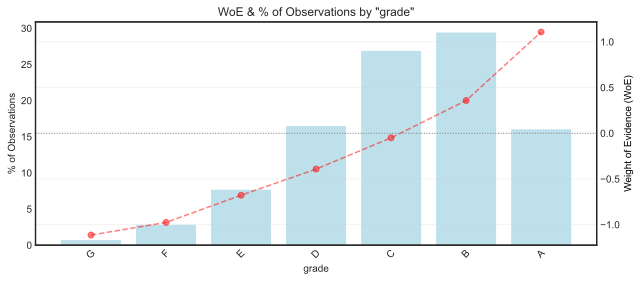

In [15]:
grade_woe_df = compute_woe_iv(loan_Xt, 'grade', loan_yt)

plot_woe_with_bins(grade_woe_df, rot_of_xlabels=45)

`WoE` plot almost shows a linear trend. This is in general a desired outcome to have an interpretable PD model because now each category is monotonic in terms of risk. For example `G` has the highest risk of default (`WoE` < 0) and the risk reduces as we move towards `A` (`WoE` > 0). Note that since we labeled 0 as default negative WoE corresponds higher probability of default whereas positive more positive values of WoE implies smaller chance of default.

The plot above shows the "raw" categories of the variable `grade`. Since we `WoE` has a monotonic and almost linear trend, we may choose to not combine any of the categories into the same bins. However, even in the case above this might be sub-optimal if one considers different metrics that identifies the "quality" of the binning one chooses.

The `optbinning` [library](https://gnpalencia.org/optbinning/) is designed to optimize the binning based on different criterions of interest or a combination thereof. It is flexible enough to adjust it depending on the requirements of your project. Below, I will use a helper function I built that carries the computation for us flexible enough to adjust it to different cases. We load it from the `feature_utils.py`:

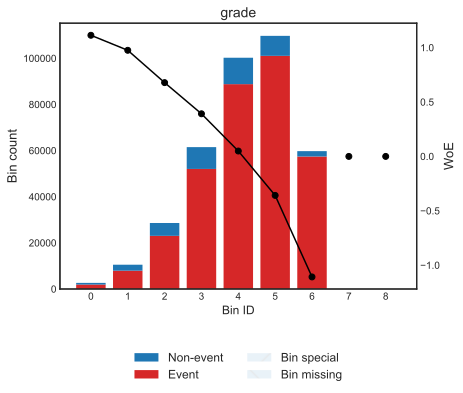

In [16]:
from feature_utils import get_woe_iv_optb

woe_table_grade, bin_table_grade, _ = get_woe_iv_optb(loan_Xt, 'grade', loan_yt, optimize_bins=False, plot = True)

In [17]:
woe_table_grade

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Ref_Bin
0,[G],2654,0.007115,722,1932,0.727958,-1.113459,0.013240,0.001574,True
1,[F],10530,0.028228,2586,7944,0.754416,-0.97544,0.038537,0.004635,False
2,[E],28612,0.076702,5572,23040,0.805257,-0.678267,0.045645,0.005599,False
3,[D],61498,0.164862,9452,52046,0.846304,-0.391843,0.029445,0.003657,False
4,[C],100245,0.268733,11451,88794,0.885770,-0.049503,0.000671,0.000084,False
5,[B],109730,0.294160,8667,101063,0.921015,0.358476,0.032850,0.004084,False
6,[A],59759,0.160200,2328,57431,0.961044,1.10783,0.128248,0.015258,False
7,Special,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
8,Missing,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
Totals,,373028,1.000000,40778,332250,0.890684,,0.288636,0.034892,False


Clearly, we reproduced the results using our customized function `compute_woe_iv()` above. We see that there are some categories with similar `WoE` like `G` and `F` however the former is rather rare, less than 1 percent of the all observations. In such cases, bins can be combined. `optbinning` can perform such optimization based on the criterion of maximum `IV`.

In [18]:
bin_table_grade.analysis(print_output = 0)

bin_table_grade.quality_score

0.8064847798674971

Quality score (max 1) of the raw binning is quite good. We may keep it as it is. However, we let `optbinning` to do its job by removing `optimize_bins = False` flag which defaults to True: 

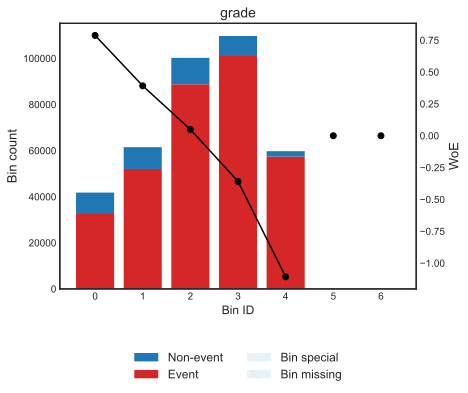

In [19]:
opt_table_grade, opt_bin_table_grade, _ = get_woe_iv_optb(loan_Xt, 'grade', loan_yt, plot = True)

In [20]:
opt_table_grade

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Ref_Bin
0,"[G, F, E]",41796,0.112045,8880,32916,0.787539,-0.787588,0.093482,0.011392,True
1,[D],61498,0.164862,9452,52046,0.846304,-0.391843,0.029445,0.003657,False
2,[C],100245,0.268733,11451,88794,0.885770,-0.049503,0.000671,0.000084,False
3,[B],109730,0.294160,8667,101063,0.921015,0.358476,0.032850,0.004084,False
4,[A],59759,0.160200,2328,57431,0.961044,1.10783,0.128248,0.015258,False
5,Special,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
6,Missing,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
Totals,,373028,1.000000,40778,332250,0.890684,,0.284696,0.034476,False


Plot shows the inverted `WoE` recalling the sign convention difference that we use as compared to `optbinning`. Taking this into consideration, we have a monotonically increasing `WoE` towards the category `A` grade. This is good news, in the context of interpretability of the model, as the credit risk is expected to be almost linearly decreasing towards category `A` starting from the bucket that consist of `G,F,E`. 

In [21]:
opt_bin_table_grade.analysis(print_output=0)
opt_bin_table_grade.quality_score

0.8288283307070073

Notice that we gained some overall quality score after fitting!. Next, we have a look to `home_ownership` using our custom method first:

In [22]:
home_own_df = compute_woe_iv(loan_Xt, 'home_ownership', loan_yt, regulate = True)

home_own_df


,cat_count,%_of_obs,good,bad,WoE,IV,total_IV
home_ownership,,,,,,,
OTHER,137,0.036726,109.0,28.0,-0.737013,0.000264,0.021392
NONE,40,0.010723,34.0,6.0,-0.360193,0.000016,0.021392
RENT,150599,40.372036,131604.0,18995.0,-0.162123,0.011302,0.021392
OWN,33295,8.925603,29717.0,3578.0,0.019170,0.000033,0.021392
MORTGAGE,188956,50.654643,170785.0,18171.0,0.142833,0.009772,0.021392
ANY,1,0.000268,1.0,0.0,1.388737,0.000004,0.021392


There are under-represented categories like `OTHER`, `NONE` that have a similar `WoE` such categories can be combined with others that has a similar `WoE` such as `RENT`. On the other hand, we have a really sparse category `ANY` that only has one instance that is for good for credit purposes, if we did not use the regulate flag in our function this would lead to infinity `WoE` and `IV`, but now it has finite positive large value. We can also combine this category with a one with similar `WoE`. 

`optbinning` can perform this procedure for us:

In [23]:
home_own_df_opt, _ , _ = get_woe_iv_optb(loan_Xt, 'home_ownership', loan_yt)

In [24]:
home_own_df_opt

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Ref_Bin
0,"[OTHER, NONE, RENT]",150776,0.404195,19029,131747,0.873793,-0.162826,0.011417,0.001426,True
1,[OWN],33295,0.089256,3578,29717,0.892536,0.01917,0.000033,0.000004,False
2,"[MORTGAGE, ANY]",188957,0.506549,18171,170786,0.903835,0.142839,0.009773,0.001221,False
3,Special,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
4,Missing,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
Totals,,373028,1.000000,40778,332250,0.890684,,0.021223,0.002650,False


- It is quite time-consuming to check each categorical variable by hand to decide if the original variable is worth including into the model. 
  
- Furthermore, if it is actually worth including the variable, we need to decide the optimal category bins based on `WoE` that the PD model can use. After we find the optimal bins for the variables we would like to include in the model, the next step is to generate dummies for those bins that the PD model can utilize. 

- For this purpose, we just go over all the categorical variables that have object dtype, i.e. `object_cat_vars` and diagnose their various metrics 

In [25]:
from feature_utils import variable_bins_diagnose

cat_var_diagnose_df = variable_bins_diagnose(loan_Xt, object_cat_vars, loan_yt)

In [26]:
cat_var_diagnose_df

,Variable,IV,Opt_IV,QS,Opt_QS,Ref_Bin,Opt_Ref_Bin
0,grade,0.288636,0.284696,0.80648,0.82883,[G],"[G, F, E]"
1,sub_grade,0.312353,0.299702,0.00000,0.51859,[F5],"[F5, G1, G3, G5, F4, G4, F3, G2, F2, E5, F1, E4, E2, E3]"
2,home_ownership,0.021389,0.021223,0.01162,0.06314,[OTHER],"[OTHER, NONE, RENT]"
3,verification_status,0.020384,0.020384,0.07056,0.07056,[Verified],[Verified]
4,pymnt_plan,0.000111,0.000000,0.00000,0.00000,[y],Special
5,purpose,0.035416,0.030495,0.00442,0.08710,[small_business],"[small_business, educational, moving, house, other, renewable_energy, medical]"
6,addr_state,0.012029,0.011038,0.00000,0.00020,[NE],"[NE, IA, NV, FL, HI, AL]"
7,initial_list_status,0.024780,0.024780,0.06250,0.06250,[f],[f]


We discard `pymnt_plan` as it has a very small `IV`. Notice that for all other non-trivial variables, i.e. ones with more than 2 categories, Quality Score after `optbinning`, rises. 

##### **First contact with Data Leakage Issues**
-----

Here we should be very careful about two variables that seemingly have very large `IV`, namely `grade`/`sub_grade`. The issue here is about a concept called data leakage. 

Although these two attributes are available at the origination so that there is no temporal leakage for a PD (probability of default) model. They are not raw borrower features, but Lending Club’s internal credit assessment. They reflect LC’s own underwriting model applied to borrower characteristics. You can think of them as a composite risk score derived from borrower features like: FICO score, Annual income, DTI, Loan amount, Employment length, Loan purpose. Therefore, although there is no temporal leak, there is a circular logic that at least introduces a multi-collinearity. Furthermore, From LC documentation and past SEC filings (from when they were public), they stated that their credit grades were assigned based on a proprietary credit scoring model using:

“Credit attributes from the credit report and application, including debt-to-income (DTI), credit utilization, loan purpose, and FICO score.”

So `grade` and `sub_grade` are outputs of a model that essentially encodes PD, in other words, they are ordinal representations of estimated probability of default (PD). For an honest and generalizable model they should be excluded!










The next step is to generate dummies for the bins generate by `optbinning`.

In [27]:
from feature_utils import get_dummies_custom

variable_list = cat_var_diagnose_df.Variable.tolist()[2:] #ignore grade, sub_grade
variable_list.pop(2) #ignore pymnt_plan 

dum_dfs_list_train = []
dum_dfs_list_val = []

for cat_var in variable_list:
        
    _ , opt_bin_table, optb = get_woe_iv_optb(loan_Xt, cat_var, loan_yt) # optimized categories 
        
    dum_dfs_list_train.append(get_dummies_custom(loan_Xt, cat_var, optb))
    dum_dfs_list_val.append(get_dummies_custom(loan_Xval, cat_var, optb))
        
loan_Xt_pp = pd.concat(dum_dfs_list_train, axis = 1)
loan_Xt_pp.columns = loan_Xt_pp.columns.str.replace('\n', '', regex=False)

loan_Xval_pp = pd.concat(dum_dfs_list_val, axis = 1)
loan_Xval_pp.columns = loan_Xval_pp.columns.str.replace('\n', '', regex=False)

The code block above gives us dummified version of the traning and validation set for the qualitative discrete variables we have been studying so far.

In [28]:
loan_Xt_pp.head()

,home_ownership:MORTGAGE-ANY,home_ownership:OTHER-NONE-RENT,home_ownership:OWN,verification_status:Not-Verified,verification_status:Source-Verified,verification_status:Verified,purpose:car-credit_card,purpose:home_improvement-major_purchase,purpose:small_business-educational-moving-house-other-renewable_energy-medical,purpose:wedding-vacation-debt_consolidation,...,addr_state:GA-WA-OR-WI,addr_state:IL-CT,addr_state:KS-SC-CO-VT-AK-MS-WV-NH-WY-DC-ME-ID,addr_state:LA-MD-NC,addr_state:MN-RI-MA-DE-SD-IN,addr_state:MT-TX,addr_state:NE-IA-NV-FL-HI-AL,addr_state:NM-VA-NY-OK-TN-MO,initial_list_status:f,initial_list_status:w
0,True,False,False,False,True,False,False,False,False,True,...,False,False,True,False,False,False,False,False,True,False
1,True,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2,True,False,False,False,False,True,False,False,False,True,...,True,False,False,False,False,False,False,False,True,False
3,False,True,False,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,True,False
4,True,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False


#### Analyzing discrete variables that take numerical values: Binning and generating dummies 
-----

- When dealing with variables that takes numerical values. One thing we need to be careful is the order of the variable because the order of their numerical values contain quantitative information. In contrast, for discrete categorical variables that take string like values there is only qualitative information contained within each category of the variable. 

- The custom function we designed to output the `WoE` and `IV` table: `compute_woe_iv()` is already suitable for numerical variables because when the `discrete = ` flag is false, the resulting df is not ordered with respect to `WoE` but in the natural (increasing) order of the numerical variable.  

In [29]:
numeric_cat_vars

['delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'emp_length_years',
 'term_in_months',
 'total_rev_hi_lim_missing',
 'missing_credit_line',
 'tot_coll_amt_missing',
 'tot_cur_bal_missing',
 'delinquency_missing',
 'record_missing',
 'major_derog_missing']

In [32]:
df_term_woe = compute_woe_iv(loan_Xt, 'term_in_months', loan_yt, ordered = True)

df_term_woe

,cat_count,%_of_obs,good,bad,WoE,IV,total_IV
term_in_months,,,,,,,
36,270419,72.49295,244187.0,26232.0,0.133209,0.012210,0.039434
60,102609,27.50705,88063.0,14546.0,-0.297009,0.027224,0.039434


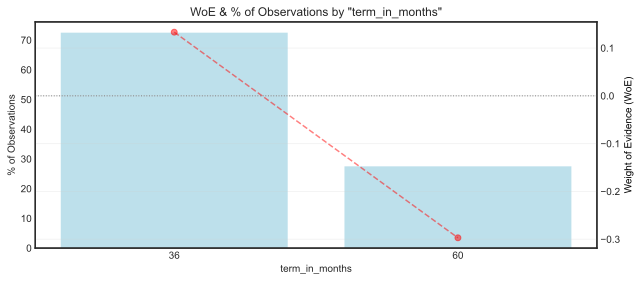

In [33]:
plot_woe_with_bins(df_term_woe)

For two categories our life is simple. We will generate dummies for two categories keeping in mind that `60` will be the reference category as it implies higher probability of default.

In [34]:
dummies_term_df = pd.get_dummies(loan_Xt['term_in_months'], prefix = 'term_in_months', prefix_sep=':')
dummies_term_val_df = pd.get_dummies(loan_Xval['term_in_months'], prefix = 'term_in_months', prefix_sep=':')

In [35]:
# concat it with the loan_Xt_pp and loan_Xval_pp 

loan_Xt_pp = pd.concat([loan_Xt_pp, dummies_term_df], axis = 1)
loan_Xval_pp = pd.concat([loan_Xval_pp, dummies_term_val_df], axis = 1)

Since all the numeric variables we are looking at have a few discrete values, we can generate `WoE` and `IV` table for all the remaining ones in one go. We can use our customized function `woe_iv`() as before because there is no need for fine classing for such variables with few discrete values. We first check

In [36]:
for var in numeric_cat_vars:
    
    print(f"{var} with {loan_Xt[var].nunique()} unique values: {loan_Xt[var].unique().tolist()}")

delinq_2yrs with 24 unique values: [0.0, 1.0, 4.0, 2.0, 5.0, 3.0, 6.0, 9.0, 8.0, 7.0, 11.0, 24.0, 10.0, 12.0, 18.0, 13.0, 14.0, 17.0, 19.0, 15.0, 16.0, 22.0, 21.0, 29.0]
inq_last_6mths with 28 unique values: [1.0, 2.0, 3.0, 0.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 12.0, 28.0, 11.0, 15.0, 14.0, 13.0, 10.0, 20.0, 16.0, 24.0, 17.0, 33.0, 18.0, 31.0, 19.0, 25.0, 27.0, 32.0]
open_acc with 61 unique values: [20.0, 15.0, 9.0, 14.0, 5.0, 13.0, 11.0, 6.0, 10.0, 7.0, 16.0, 4.0, 8.0, 12.0, 17.0, 3.0, 18.0, 26.0, 24.0, 2.0, 19.0, 25.0, 27.0, 30.0, 23.0, 22.0, 21.0, 1.0, 29.0, 33.0, 28.0, 34.0, 0.0, 41.0, 38.0, 32.0, 37.0, 31.0, 42.0, 40.0, 45.0, 46.0, 35.0, 36.0, 39.0, 44.0, 43.0, 49.0, 50.0, 53.0, 47.0, 48.0, 55.0, 51.0, 54.0, 62.0, 76.0, 84.0, 58.0, 52.0, 75.0]
pub_rec with 24 unique values: [0.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, 7.0, 9.0, 10.0, 13.0, 8.0, 19.0, 11.0, 17.0, 34.0, 16.0, 12.0, 40.0, 18.0, 54.0, 15.0, 63.0, 21.0]
collections_12_mths_ex_med with 9 unique values: [0.0, 1.0, 2.0, 3.0, 16.0, 4.

In [37]:
# lets generate WoE and IV table for all 

dfs_woe = {}

for var in numeric_cat_vars:
    
    # we have done `term_in_months` already
    if var != 'term_in_months':
        
        dfs_woe[var] = compute_woe_iv(loan_Xt, var, loan_yt, ordered = True, regulate = True)

In [38]:
dfs_woe['emp_length_years']

,cat_count,%_of_obs,good,bad,WoE,IV,total_IV
emp_length_years,,,,,,,
0,45720,12.256453,40069.0,5651.0,-0.138973,2.498837e-03,0.006506
1,23654,6.341079,20981.0,2673.0,-0.037329,8.965649e-05,0.006506
2,33078,8.867431,29471.0,3607.0,0.002785,6.871946e-07,0.006506
3,29205,7.829171,26015.0,3190.0,0.000907,6.443984e-08,0.006506
4,22468,6.023140,20011.0,2457.0,-0.000404,9.829610e-09,0.006506
5,24602,6.595215,21766.0,2836.0,-0.059790,2.413343e-04,0.006506
6,20887,5.599312,18462.0,2425.0,-0.067861,2.647757e-04,0.006506
7,21049,5.642740,18680.0,2369.0,-0.032759,6.133538e-05,0.006506
8,17853,4.785968,15887.0,1966.0,-0.008245,3.263798e-06,0.006506


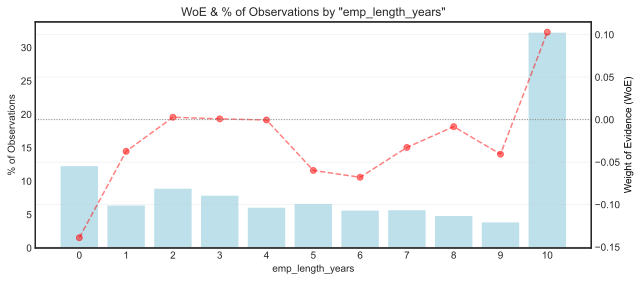

In [39]:
plot_woe_with_bins(dfs_woe['emp_length_years'])

Looking at this plot, non-monotonicity of the categories in terms of `WoE` signals us already that `emp_length_years` may not be very useful for the PD model. We can choose to bin by visual inspection of the plot above merging categories that has a similar `WoE` and check if we get improvement in terms of monotonicity. 

To decide which variables we can utilize in the model we can use `optbinning`: by first checking the `IV` and Quality score of raw categories of the variable and compare it with the suggested bins by `optbinning`. 

In [40]:
cat_num_var_diagnose_df = variable_bins_diagnose(loan_Xt, numeric_cat_vars, loan_yt)

cat_num_var_diagnose_df

,Variable,IV,Opt_IV,QS,Opt_QS,Ref_Bin,Opt_Ref_Bin
0,delinq_2yrs,0.000596,0.000132,0.00000,0.00019,[21.0],"[1.50, inf)"
1,inq_last_6mths,0.051290,0.048376,0.00022,0.15174,"[32.0, 25.0, 33.0, 20.0, 14.0]","[2.50, inf)"
2,open_acc,0.002347,0.000612,0.00000,0.00009,"[76.0, 0.0]","[10.50, 11.50)"
3,pub_rec,0.001088,0.000391,0.00000,0.00050,[9.0],"(-inf, 0.50)"
4,collections_12_mths_ex_med,0.000266,0.000000,0.00001,0.00000,[4.0],Special
5,acc_now_delinq,0.000110,0.000000,0.00000,0.00000,[5.0],Special
6,emp_length_years,0.006506,0.006136,0.00000,0.00942,[0],"(-inf, 0.50)"
7,term_in_months,0.039434,0.039434,0.08693,0.08693,[60],"[48.00, inf)"
8,total_rev_hi_lim_missing,0.035333,0.035333,0.05011,0.05011,[1],"[0.50, inf)"
9,missing_credit_line,0.000002,0.000000,0.00000,0.00000,[1],Special


Observe that many features we engineered do not contain useful information in distinguishing the target label!

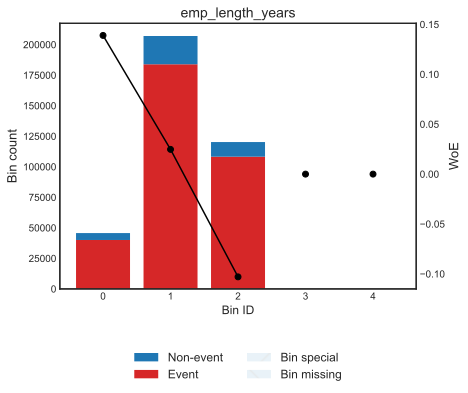

In [128]:
df_woe_opt_emp , opt_bin_table_emp, _ = get_woe_iv_optb(loan_Xt, 'emp_length_years', loan_yt, plot = True,
                                                        max_n_bins = 3)

In [129]:
opt_bin_table_emp.analysis(print_output = 0)

opt_bin_table_emp.quality_score

0.018272962061045197

In [131]:
df_woe_opt_emp

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Ref_Bin
0,"(-inf, 0.50)",45720,0.122565,5651,40069,0.876400,-0.138975,0.002499,0.000312,True
1,"[0.50, 9.50)",207063,0.555087,23140,183923,0.888247,-0.024791,0.000344,0.000043,False
2,"[9.50, inf)",120245,0.322348,11987,108258,0.900312,0.10295,0.003282,0.000410,False
3,Special,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
4,Missing,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
Totals,,373028,1.000000,40778,332250,0.890684,,0.006125,0.000765,False


We will take into account `emp_length_years`, although it has `IV < 0.02` as it is quite a fundamental variable that provides useful information about borrower. It could be even more useful in an interaction term. Note that Quality score of the binning is optimal when we restrict the number of bins to 3! as, opposed to the default binning with 4 bins! 

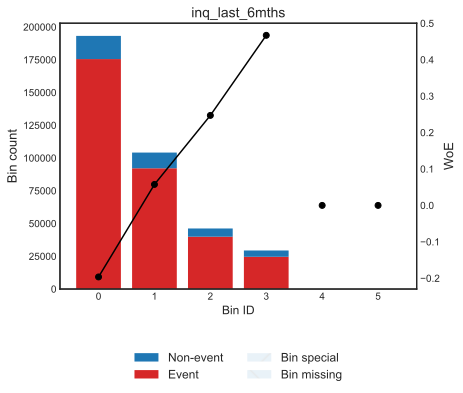

In [132]:
df_woe_opt_inq , opt_bin_table_inq, _ = get_woe_iv_optb(loan_Xt, 'inq_last_6mths', loan_yt, plot = True)

In [133]:
df_woe_opt_inq

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Ref_Bin
0,"(-inf, 0.50)",193232,0.518009,17701,175531,0.908395,0.19645,0.018511,0.002310,False
1,"[0.50, 1.50)",104163,0.279236,11984,92179,0.884950,-0.057585,0.000947,0.000118,False
2,"[1.50, 2.50)",46214,0.123889,6276,39938,0.864197,-0.24715,0.008329,0.001039,False
3,"[2.50, inf)",29419,0.078865,4817,24602,0.836262,-0.467069,0.020589,0.002550,True
4,Special,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
5,Missing,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
Totals,,373028,1.000000,40778,332250,0.890684,,0.048376,0.006018,False


In [46]:
oa_df = compute_woe_iv(loan_Xt, 'open_acc', loan_yt, ordered = True, regulate = True)

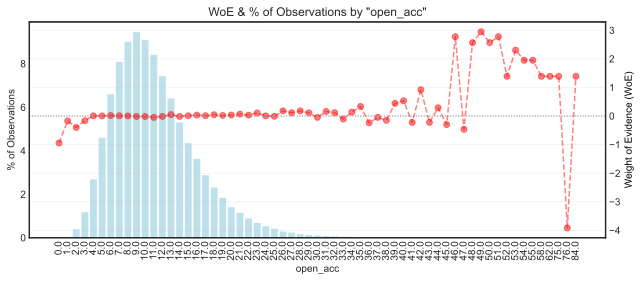

In [47]:
plot_woe_with_bins(oa_df, rot_of_xlabels=90)

The analysis above suggest that except `emp_length_years`, `inq_last_6mths`, `term_in_months`, `tot_coll_amt_missing`, `tot_cur_bal_missing` there are no useful discrete numerical variables that the PD model can benefit from. We just need to bin `emp_length_years`, `inq_last_6mths`, just as `term_in_months`. Note that `tot_coll_amt_missing`, `tot_cur_bal_missing` are already binary variables, so we do not need to bin them as they indicate missing data.

For `inq_last_6mths`, the suggested binning by `optbinning` above seems quite optimal given the monotonic trend in `WoE` for bins of increasing order. 

We will have four bins, 

- the first one will have the instances that only have value equal to 0
- the second one will have the instances that only have value equal to 1
- the third one will have the instances that only have value equal to 2
- the fourth one will have the instances that have values larger than 2, i.e. > 2, including 3,4,5,6 ... 33

In [134]:
# dummies for inq_last_6mths by hand 

max_inq_last_6mths_str = str(int(loan_Xt.inq_last_6mths.max())) # stringified max value of inq_last_6_mths variable

exclude_fourth = [0,1,2] # categories in the first 3 bins

check_list_fourth = [x for x in loan_Xt.inq_last_6mths.unique().tolist() if x not in exclude_fourth]

# train set
loan_Xt_pp['inq_last_6mths:0'] = np.where(loan_Xt['inq_last_6mths'].isin([0]), True, False)
loan_Xt_pp['inq_last_6mths:1'] = np.where(loan_Xt['inq_last_6mths'].isin([1]), True, False)
loan_Xt_pp['inq_last_6mths:2'] = np.where(loan_Xt['inq_last_6mths'].isin([2]), True, False)
loan_Xt_pp['inq_last_6mths:3-' + max_inq_last_6mths_str] = np.where(loan_Xt['inq_last_6mths'].isin(check_list_fourth), True, False)

# validation set
loan_Xval_pp['inq_last_6mths:0'] = np.where(loan_Xval['inq_last_6mths'].isin([0]), True, False)
loan_Xval_pp['inq_last_6mths:1'] = np.where(loan_Xval['inq_last_6mths'].isin([1]), True, False)
loan_Xval_pp['inq_last_6mths:2'] = np.where(loan_Xval['inq_last_6mths'].isin([2]), True, False)
loan_Xval_pp['inq_last_6mths:3-' + max_inq_last_6mths_str] = np.where(loan_Xval['inq_last_6mths'].isin(check_list_fourth), True, False)


In [135]:
loan_Xt_pp['emp_length:0'] = np.where(loan_Xt['emp_length_years'].isin([0]), True, False)
loan_Xt_pp['emp_length:1-9'] = np.where((loan_Xt['emp_length_years'] >= 1) & (loan_Xt['emp_length_years'] <= 9), True, False)
loan_Xt_pp['emp_length:10'] = np.where(loan_Xt['emp_length_years'].isin([10]), True, False)

loan_Xval_pp['emp_length:0'] = np.where(loan_Xval['emp_length_years'].isin([0]), True, False)
loan_Xval_pp['emp_length:1-9'] = np.where((loan_Xval['emp_length_years'] >= 1) & (loan_Xval['emp_length_years'] <= 9), True, False)
loan_Xval_pp['emp_length:10'] = np.where(loan_Xval['emp_length_years'].isin([10]), True, False)

In [136]:
# concat raw tot_cur_bal_missing and tot_coll_amt_missing with the loan_Xt_pp and loan_Xval_pp 

loan_Xt_pp = pd.concat([loan_Xt_pp, loan_Xt[['tot_coll_amt_missing','tot_cur_bal_missing']]], axis = 1)
loan_Xval_pp = pd.concat([loan_Xval_pp, loan_Xval[['tot_coll_amt_missing','tot_cur_bal_missing']]], axis = 1)

#### Analyzing continuous variables: Binning and generating dummies 
-----

For variables that are continuous, we first need to perform a type of fine classing by dividing the range of the variable into equally spaced ranges. These will represent our raw categories for the variable. We can then merge certain categories for the optimality of the predictors in assessing the credit risk as we have done above. 

As we mentioned before for continuous variables we need an extra initial step: 

1) Fine classing: roughly grouping the values into categories characterized by ranges
2) Course classing: determining final categories by combining some initial fine classed categories into bigger ones, if necessary.

In [137]:
# discrete variables numeric discrete + qualitative discrete
discrete_vars = []
discrete_vars.extend(numeric_cat_vars)
discrete_vars.extend(object_cat_vars)

# variables in the training set that take more than 60 values 
all_training_cols = loan_Xt.columns.tolist()

continuous_vars = [var for var in all_training_cols if var not in discrete_vars]
continuous_vars.append('open_acc') #add open_acc as continuous variable as well to double check

loan_Xt_cont = loan_Xt[continuous_vars]
loan_Xval_cont = loan_Xval[continuous_vars]

loan_Xt_cont.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,mths_since_last_delinq,mths_since_last_record,revol_bal,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,mths_since_last_major_derog,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,open_acc
0,24000,24000,24000.0,8.90,762.08,77000.0,21.91,240.0,240.0,30489,...,0.00,0.00,0.000,762.08,240.0,0.0,348253.0,57000.0,332.0,20.0
1,10000,10000,10000.0,14.33,343.39,112000.0,7.49,18.0,240.0,15836,...,0.00,0.00,0.000,355.11,240.0,0.0,81539.0,22800.0,179.0,15.0
2,20425,20425,20425.0,8.90,648.56,84000.0,14.83,46.0,240.0,29813,...,0.00,0.00,0.000,648.56,240.0,0.0,385187.0,33300.0,267.0,9.0
3,17200,17200,17200.0,16.59,609.73,43000.0,13.68,6.0,240.0,7523,...,30.49,0.00,0.000,640.22,50.0,0.0,22958.0,12500.0,189.0,9.0
4,8400,8400,7450.0,12.84,282.40,94000.0,22.54,240.0,240.0,65621,...,0.00,623.79,28.256,282.40,240.0,0.0,81539.0,22800.0,134.0,14.0


In [63]:
for var in continuous_vars:
    
    print(f"Variable {var} has {loan_Xt_cont[var].nunique()} unique values")

Variable loan_amnt has 1341 unique values
Variable funded_amnt has 1344 unique values
Variable funded_amnt_inv has 8219 unique values
Variable int_rate has 504 unique values
Variable installment has 51429 unique values
Variable annual_inc has 26892 unique values
Variable dti has 3997 unique values
Variable mths_since_last_delinq has 140 unique values
Variable mths_since_last_record has 123 unique values
Variable revol_bal has 54594 unique values
Variable revol_util has 1237 unique values
Variable total_acc has 112 unique values
Variable out_prncp has 112854 unique values
Variable out_prncp_inv has 117253 unique values
Variable total_pymnt has 288213 unique values
Variable total_pymnt_inv has 286340 unique values
Variable total_rec_prncp has 143860 unique values
Variable total_rec_int has 231356 unique values
Variable total_rec_late_fee has 4873 unique values
Variable recoveries has 18400 unique values
Variable collection_recovery_fee has 16404 unique values
Variable last_pymnt_amnt has

In [138]:
# Fine classing with pd.cut

fine_classed_dfs = []

for var in continuous_vars:
    
    # dividing each variable to 150 equally spaced bins is questionable (might not be optimal for all variables)
    fine_classed_dfs.append(pd.cut(loan_Xt_cont[var],150, duplicates='drop', include_lowest = True))
    
fine_classed_Xt_cont = pd.concat(fine_classed_dfs,axis = 1)

In [139]:

for idx, var in enumerate(continuous_vars):
    
    woe_table = compute_woe_iv(fine_classed_Xt_cont, var, loan_yt, ordered = True, regulate = True)
    
        
    # eliminate suspicously high IV variables, 
    #  due to data leakage that can not be known ahead of decision making
    if woe_table['total_IV'].min() >= 0.7:
        
        continuous_vars.pop(idx) # delete the var from continuous_vars
    
    else:    
        
        print(f"Fine classed (150 categories) variable, {var} --> IV: {woe_table['total_IV'].min():.4f}")
    

Fine classed (150 categories) variable, loan_amnt --> IV: 0.0345
Fine classed (150 categories) variable, funded_amnt --> IV: 0.0348
Fine classed (150 categories) variable, funded_amnt_inv --> IV: 0.0372
Fine classed (150 categories) variable, int_rate --> IV: 0.3893
Fine classed (150 categories) variable, installment --> IV: 0.0208
Fine classed (150 categories) variable, annual_inc --> IV: 0.0471
Fine classed (150 categories) variable, dti --> IV: 0.0301
Fine classed (150 categories) variable, mths_since_last_delinq --> IV: 0.0037
Fine classed (150 categories) variable, mths_since_last_record --> IV: 0.0116
Fine classed (150 categories) variable, revol_bal --> IV: 0.0073
Fine classed (150 categories) variable, revol_util --> IV: 0.0280
Fine classed (150 categories) variable, total_acc --> IV: 0.0105
Fine classed (150 categories) variable, total_rec_late_fee --> IV: 0.1691
Fine classed (150 categories) variable, tot_coll_amt --> IV: 0.0001
Fine classed (150 categories) variable, tot_cur

Looking at fine classed continuous variables, we can consider `loan_amnt`, `funded_amnt`, `funded_amnt_inv`, `int_rate`, `installment`, `annual_inc`, `dti`, `revol_util`, `total_rec_int` `total_rec_late_fee`, `tot_cur_bal`, `total_rev_hi_lim`, `mths_since_earliest_cr_line` along with possibly `mths_since_last_record`, `revol_bal`, `total_acc` which do not have too small `IV`

In [140]:
desc_lookup_vars = ['loan_amnt', 'funded_amnt','funded_amnt_inv', 'int_rate', 'installment',
                    'annual_inc', 'dti', 'revol_util',
                    'total_rec_int', 'total_rec_late_fee', 'tot_cur_bal',
                    'total_rev_hi_lim', 'mths_since_last_record', 'revol_bal', 'total_acc', 'open_acc']
for var in desc_lookup_vars:
    
    print(f"{var}: {col_desc_dict[var]}")

loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
funded_amnt: The total amount committed to that loan at that point in time.
funded_amnt_inv: The total amount committed by investors for that loan at that point in time.
int_rate: Interest Rate on the loan
installment: The monthly payment owed by the borrower if the loan originates.
annual_inc: The self-reported annual income provided by the borrower during registration.
dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
total_rec_int: Interest received to date
total_rec_late_fee: Late fees received to date
tot_cur_bal: 

Note that `revol_bal` is directly related to `revol_util` via `revol_util` = `revol_bal` / `total_rev_hi_lim`. Since `revol_bal` seems to carry less information, we can ignore it unless we are planning to feature other variables using it! For now, we will not consider `revol_bal` but keep `total_acc` that we might benefit later.

#### **A second contact with Data Leakage**:

We should be careful about some of these variables, as they have data leakage issues, that is they carry information from the post loan origination. Since we are planning to predict probability of default (or credit risk), based only on information available at loan application time, this would be problematic. 

0. `funded_amnt`: is not available at the time the application is submitted. Data leakage if utilized!

1. `funded_amnt_inv` : 	Shows how much investors have committed. This is after the loan has been evaluated and approved. Not known at app time. So it would cause data leakage, we will not consider it!

2. `int_rate`: set by Lending Club, after evaluating the applicant's credit risk. Not part of the initial application — it’s an output of Lending Club’s internal credit risk model. We will not consider it! 

3. `installment`: Although the loan amount and term come from the borrower's application, the interest rate is set by Lending Club, based on their internal credit model which is used to calculate `installment = loan_amnt * f(int_rate, term)`

4. `total_rec_int` : The total amount of interest payments collected on the loan to date. Appears only after the loan is issued and begins repayment. Data Leakage!

5. `total_rec_late_fee`: Late fees received to date. It's a post-event variable: Late fees are charged after a borrower has missed a payment.  If your target is default in the future (e.g., next 12 months), then this variable reflects an outcome that has already occurred, not something that predicts it. So these variables "peeks into the future" relative to the moment of application. So, although `IV` > 0.02, we will ignore them. 





- `mths_since_earliest_cr_line`:

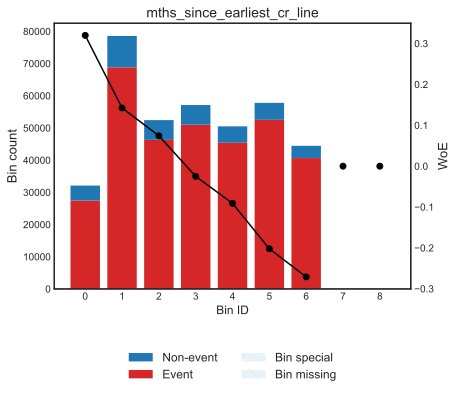

In [141]:
woetab_earliest_cr_line, bt_cr_line, optb = get_woe_iv_optb(loan_Xt, "mths_since_earliest_cr_line", 
                                                            loan_yt, plot= True, max_n_bins = 7)

In [142]:
# largest QS without damaging the total IV above!
bt_cr_line.analysis(print_output=0)
bt_cr_line.quality_score

0.1193132592319539

Above analysis gives the optimization with the maximal Quality score for `mths_since_earliest_cr_line`. 


Taking into account data leakage issues we discussed above, we have to give up some variables with strong `IV`, this leaves us with

`loan_amnt` `annual_inc`, `dti`, `revol_util`, `tot_cur_bal`, `total_rev_hi_lim` and `mths_since_earliest_cr_line`, `mths_since_last_record`, `total_acc` as the predictors to be added to the model. First we need to find the optimal bins for these variables and create dummies for them accordingly.



We limit the maximum number of bins to get the most out of the binning process, this is a rough approach, we could treat it as a hyper-parameter to reach the maximum quality score for each variable. 

In [143]:
binning_tables = {}
woe_iv_tables = {}
ref_bin_dict_num_con = {}

vars_to_dummy = ["loan_amnt", "annual_inc", "dti", 'revol_util', 'tot_cur_bal', 
                 'total_rev_hi_lim', 'mths_since_last_record', 'total_acc', 'open_acc']

for var in vars_to_dummy:
    
    woe_table, bin_table, optb = get_woe_iv_optb(loan_Xt_cont, var, loan_yt, plot = False, max_n_bins = 6)
        
    woe_iv_tables[var] = woe_table
    binning_tables[var] = bin_table    
    bin_table.analysis(print_output=0)
    ref_bin_dict_num_con[var] = woe_table['Bin'][woe_table['Ref_Bin'] == True].values[0]
    
    print(f"Binned variable: {var}, IV: {bin_table.iv:.4f}, Quality Score of binning: {bin_table.quality_score:.4f}, status: {optb.status}")



Binned variable: loan_amnt, IV: 0.0035, Quality Score of binning: 0.0037, status: OPTIMAL
Binned variable: annual_inc, IV: 0.0540, Quality Score of binning: 0.2110, status: OPTIMAL
Binned variable: dti, IV: 0.0258, Quality Score of binning: 0.1009, status: OPTIMAL
Binned variable: revol_util, IV: 0.0270, Quality Score of binning: 0.1025, status: OPTIMAL
Binned variable: tot_cur_bal, IV: 0.0641, Quality Score of binning: 0.2305, status: OPTIMAL
Binned variable: total_rev_hi_lim, IV: 0.0626, Quality Score of binning: 0.2175, status: OPTIMAL
Binned variable: mths_since_last_record, IV: 0.0037, Quality Score of binning: 0.0045, status: OPTIMAL
Binned variable: total_acc, IV: 0.0076, Quality Score of binning: 0.0258, status: OPTIMAL
Binned variable: open_acc, IV: 0.0006, Quality Score of binning: 0.0007, status: OPTIMAL


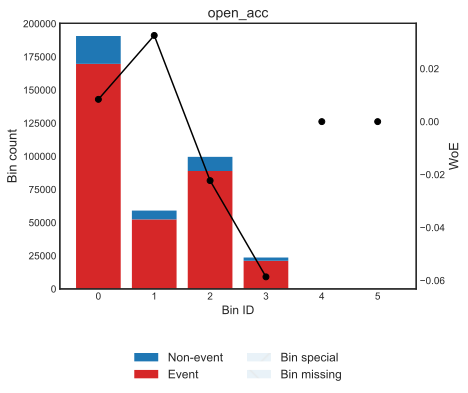

In [264]:

vars_to_improv = ['mths_since_last_record', 'total_acc', 'open_acc', 'loan_amnt', 'total_rev_hi_lim', 'revol_util']

df, bt, optb = get_woe_iv_optb(loan_Xt_cont, vars_to_improv[2], loan_yt, 
                               plot = True, prebinning_method = 'cart', max_n_bins = 4)

In [262]:
df

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Ref_Bin
0,"(-inf, 10.50)",190698,0.511216,21003,169695,0.889863,-0.008408,0.000036,0.000005,False
1,"[10.50, 11.50)",31372,0.084101,3579,27793,0.885917,-0.048044,0.000198,0.000025,True
2,"[11.50, 12.50)",27699,0.074254,3068,24631,0.889238,-0.014765,0.000016,0.000002,False
3,"[12.50, 19.50)",99584,0.266961,10672,88912,0.892834,0.022279,0.000131,0.000016,False
4,"[19.50, inf)",23675,0.063467,2456,21219,0.896262,0.058618,0.000213,0.000027,False
5,Special,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
6,Missing,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
Totals,,373028,1.000000,40778,332250,0.890684,,0.000595,0.000074,False


In [146]:
splits = optb.splits

In [237]:
bt.analysis(print_output = 0)
bt.quality_score

0.02573870944605097

In [148]:
from optbinning import OptimalBinning
# Step 3: Merge first two bins by removing the first split point
new_splits = [splits[1], splits[2], splits[3]]


# Step 4: Refit with modified binning
optb_adjusted = OptimalBinning(name="total_rev_hi_lim", dtype="numerical",
                               monotonic_trend="auto", solver="cp", divergence = 'iv', user_splits=new_splits)
optb_adjusted.fit(loan_Xt_cont['total_rev_hi_lim'].values, loan_yt.values)

# Step 5: Get the new binning table
woe_table_ad = optb_adjusted.binning_table.build()
woe_table_ad["WoE"] = -1 * woe_table_ad["WoE"]  # Optional: match your WoE convention

min_woe = pd.to_numeric(woe_table_ad.loc[:,'WoE']).min()

woe_table_ad['Ref_Bin'] = (woe_table_ad['WoE'] == min_woe)

In [149]:
bt = optb_adjusted.binning_table
bt.analysis(print_output = 0)
bt.quality_score

0.1363702010418455

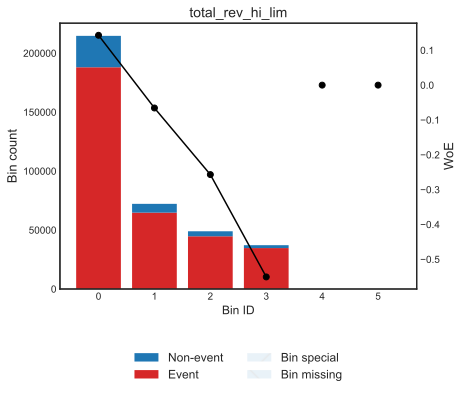

In [150]:
optb_adjusted.binning_table.plot(metric="woe")

Let have a little closer look at `tot_cur_bal`:

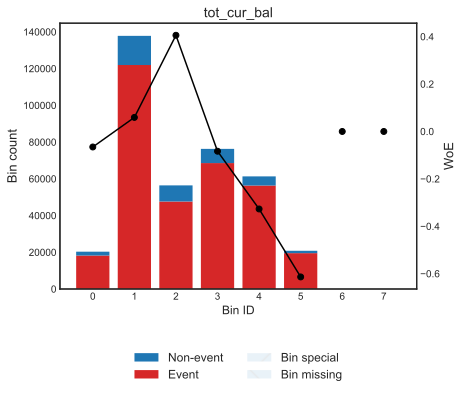

In [151]:
binning_tables['tot_cur_bal'].plot(metric = 'woe')

We see that bin's found by the `optbinning` has a non-monotonous `WoE` profile which result in assigning the second bin as the reference bin with the most negative `WoE`. We will try to improve this situation below by merging some bins together by hand. 

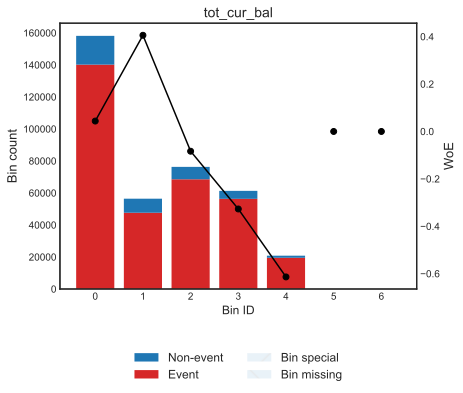

In [152]:
woe_table, bin_table, optb = get_woe_iv_optb(loan_Xt_cont, 'tot_cur_bal', loan_yt, plot = True, prebinning_method = 'cart', max_n_bins = 5)

bin_table.analysis(print_output = 0)
# Step 2: Get current splits
splits = optb.splits

`splits` give us the boundary of the bins above:

In [153]:
splits

array([ 81470. ,  81646. , 203641.5, 385746. ])

We merge first two bins together by defining a new split points and pass it to the optimizer: 

In [154]:
from optbinning import OptimalBinning
# Step 3: Merge first two bins by removing the first split point
new_splits = [splits[1], splits[2], splits[3]]


# Step 4: Refit with modified binning
optb_adjusted = OptimalBinning(name="tot_cur_bal", dtype="numerical",
                               monotonic_trend="ascending", solver="cp", divergence = 'iv', user_splits=new_splits)
optb_adjusted.fit(loan_Xt_cont['tot_cur_bal'].values, loan_yt.values)

# Step 5: Get the new binning table
woe_table_ad2 = optb_adjusted.binning_table.build()
woe_table_ad2["WoE"] = -1 * woe_table_ad2["WoE"]  # Optional: match your WoE convention

min_woe = pd.to_numeric(woe_table_ad2.loc[:,'WoE']).min()

woe_table_ad2['Ref_Bin'] = (woe_table_ad2['WoE'] == min_woe)

In [155]:
bt = optb_adjusted.binning_table
bt.analysis(print_output = 0)
bt.quality_score

0.1389555337575502

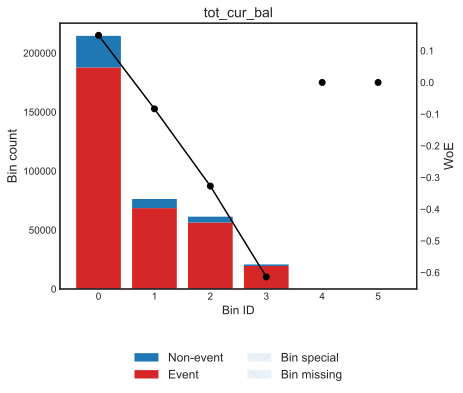

In [156]:
optb_adjusted.binning_table.plot(metric="woe")

Although the first bin is inflated in count, we have a nice linear risk profile of the new bins!
Borrowers with higher total current balance have lower default risk! We should replace the value of the corresponding key in the  `woe_iv_tables` dictionary!

In [157]:
woe_iv_tables['total_rev_hi_lim'] = woe_table_ad
woe_iv_tables['tot_cur_bal'] = woe_table_ad2

The analysis above makes us question some of our decisions earlier, especially to include `loan_amnt` which appeared to have a strong IV when we perform fine-classing. However, we saw that this is misleading as optbinning is robust. Similarly, we are going to ignore `mths_since_last_record`!

Let's dummy `annual_inc`, `dti`, `tot_cur_bal`, `revol_util`, `total_rev_hi_lim`, `total_acc`

In [71]:
import re

def extract_numbers(interval_str):
    # Find bounds or 'inf'
    matches = re.findall(r'-?\d+\.?\d*|inf', interval_str)
    return matches

In [72]:
var_list = ["annual_inc", "dti", "tot_cur_bal", "revol_util", 'total_rev_hi_lim', 'total_acc']

bounds_dict = {}

for var in var_list: 
    
    if var in ['tot_cur_bal','total_rev_hi_lim']:
        
        bounds_dict[var] = woe_iv_tables[var].loc[:3, 'Bin'].apply(extract_numbers).to_list()
    
    else:   
        
        bounds_dict[var] = woe_iv_tables[var].loc[:5, 'Bin'].apply(extract_numbers).to_list()


In [73]:
for var, bounds in bounds_dict.items():
    
   loan_Xt_pp.loc[:,f"{var}:<{bounds[0][1]}"] = np.where(loan_Xt_cont[var] < float(bounds[0][1]), True, False)
   loan_Xval_pp.loc[:,f"{var}:<{bounds[0][1]}"] = np.where(loan_Xval_cont[var] < float(bounds[0][1]), True, False)

In [74]:
for var, bounds in bounds_dict.items():
    
    for bound in bounds:
        
        if 'inf' not in bound:
            
            loan_Xt_pp.loc[:,f"{var}:{bound[0]}-{bound[1]}"] = np.where((loan_Xt_cont[var] >= float(bound[0])) & (loan_Xt_cont[var] < float(bound[1])), True, False)
            loan_Xval_pp.loc[:,f"{var}:{bound[0]}-{bound[1]}"] = np.where((loan_Xval_cont[var] >= float(bound[0])) & (loan_Xval_cont[var] < float(bound[1])), True, False)          

In [75]:
for var, bounds in bounds_dict.items():
    
   loan_Xt_pp.loc[:,f"{var}:>{bounds[-1][0]}"] = np.where(loan_Xt_cont[var] > float(bounds[-1][0]), True, False)
   loan_Xval_pp.loc[:,f"{var}:>{bounds[-1][0]}"] = np.where(loan_Xval_cont[var] > float(bounds[-1][0]), True, False)

In [76]:
# Finally dummify mths_since_earliest_cr_line

var = 'mths_since_earliest_cr_line'
cr_line_bounds_list = woetab_earliest_cr_line.loc[:6, 'Bin'].apply(extract_numbers).to_list()

for bound in cr_line_bounds_list:
    
    if bound[0] == 'inf':
            
        loan_Xt_pp.loc[:,f"{var}:<{bound[1]}"] = np.where(loan_Xt_cont[var] < float(bound[1]), True, False)
        loan_Xval_pp.loc[:,f"{var}:<{bound[1]}"] = np.where(loan_Xval_cont[var] < float(bound[1]), True, False)
            
    elif bound[1] == 'inf':
            
        loan_Xt_pp.loc[:,f"{var}:>{bound[0]}"] = np.where(loan_Xt_cont[var] > float(bound[0]), True, False)
        loan_Xval_pp.loc[:,f"{var}:>{bound[0]}"] = np.where(loan_Xval_cont[var] > float(bound[0]), True, False)
            
    else:
            
        loan_Xt_pp.loc[:,f"{var}:{bound[0]}-{bound[1]}"] = np.where((loan_Xt_cont[var] >= float(bound[0])) & (loan_Xt_cont[var] < float(bound[1])), True, False)
        loan_Xval_pp.loc[:,f"{var}:{bound[0]}-{bound[1]}"] = np.where((loan_Xval_cont[var] >= float(bound[0])) & (loan_Xval_cont[var] < float(bound[1])), True, False)

Now we have a full dummies df for predictors that are binned to have strong enough relationship with the target class!

Finally, we need the list of reference bins for all the binned variables we choose to work with! We will drop the reference category in order to remove the multi-collinearity present within a variable!

In [77]:
cat_ref_bins_df = pd.concat([cat_var_diagnose_df[['Variable', 'Opt_Ref_Bin']],
                             cat_num_var_diagnose_df[['Variable', 'Opt_Ref_Bin']]], axis = 0)
cat_ref_bins_df

,Variable,Opt_Ref_Bin
0,grade,"[G, F, E]"
1,sub_grade,"[F5, G1, G3, G5, F4, G4, F3, G2, F2, E5, F1, E4, E2, E3]"
2,home_ownership,"[OTHER, NONE, RENT]"
3,verification_status,[Verified]
4,pymnt_plan,Special
5,purpose,"[small_business, educational, moving, house, other, renewable_energy, medical]"
6,addr_state,"[NE, IA, NV, FL, HI, AL]"
7,initial_list_status,[f]
0,delinq_2yrs,"[1.50, inf)"
1,inq_last_6mths,"[2.50, inf)"


In [78]:
# update the tot_cur_bal and total_rev_hi_lim according to the new binning analysis 
ref_bin_dict_num_con['tot_cur_bal'] = woe_iv_tables['tot_cur_bal']['Bin'][woe_iv_tables['tot_cur_bal']['Ref_Bin'] == True].values[0]
ref_bin_dict_num_con['total_rev_hi_lim'] = woe_iv_tables['total_rev_hi_lim']['Bin'][woe_iv_tables['total_rev_hi_lim']['Ref_Bin'] == True].values[0]

In [79]:
ref_bin_dict_num_con

{'loan_amnt': '[17037.50, 19887.50)',
 'annual_inc': '(-inf, 37038.50)',
 'dti': '[26.44, inf)',
 'revol_util': '[89.75, inf)',
 'tot_cur_bal': '(-inf, 81646.00)',
 'total_rev_hi_lim': '(-inf, 22825.00)',
 'mths_since_last_record': '[79.50, 116.50)',
 'total_acc': '(-inf, 10.50)'}

In [80]:
del ref_bin_dict_num_con['loan_amnt']
del ref_bin_dict_num_con['mths_since_last_record']

In [ ]:
"annual_inc", "dti", "tot_cur_bal", "revol_util", 'total_rev_hi_lim', 'total_acc'

In [81]:
ref_bin_dict_num_con

{'annual_inc': '(-inf, 37038.50)',
 'dti': '[26.44, inf)',
 'revol_util': '[89.75, inf)',
 'tot_cur_bal': '(-inf, 81646.00)',
 'total_rev_hi_lim': '(-inf, 22825.00)',
 'total_acc': '(-inf, 10.50)'}

In [82]:
ref_bin_dict_num_con['mths_since_earliest_cr_line'] = (woetab_earliest_cr_line['Bin']
                                                       [woetab_earliest_cr_line['Ref_Bin'] == True].values[0])

In [83]:
ref_bin_dict_num_con

{'annual_inc': '(-inf, 37038.50)',
 'dti': '[26.44, inf)',
 'revol_util': '[89.75, inf)',
 'tot_cur_bal': '(-inf, 81646.00)',
 'total_rev_hi_lim': '(-inf, 22825.00)',
 'total_acc': '(-inf, 10.50)',
 'mths_since_earliest_cr_line': '(-inf, 89.50)'}

In [84]:
con_ref_bins_df = pd.DataFrame(list(ref_bin_dict_num_con.items()), columns=['Variable', 'Opt_Ref_Bin'])
con_ref_bins_df

,Variable,Opt_Ref_Bin
0,annual_inc,"(-inf, 37038.50)"
1,dti,"[26.44, inf)"
2,revol_util,"[89.75, inf)"
3,tot_cur_bal,"(-inf, 81646.00)"
4,total_rev_hi_lim,"(-inf, 22825.00)"
5,total_acc,"(-inf, 10.50)"
6,mths_since_earliest_cr_line,"(-inf, 89.50)"


In [85]:
# merge it with the qualitative and quantiative discrete vars 

ref_bins_df = pd.concat([cat_ref_bins_df,con_ref_bins_df], axis = 0)

ref_bins_df

,Variable,Opt_Ref_Bin
0,grade,"[G, F, E]"
1,sub_grade,"[F5, G1, G3, G5, F4, G4, F3, G2, F2, E5, F1, E4, E2, E3]"
2,home_ownership,"[OTHER, NONE, RENT]"
3,verification_status,[Verified]
4,pymnt_plan,Special
5,purpose,"[small_business, educational, moving, house, other, renewable_energy, medical]"
6,addr_state,"[NE, IA, NV, FL, HI, AL]"
7,initial_list_status,[f]
0,delinq_2yrs,"[1.50, inf)"
1,inq_last_6mths,"[2.50, inf)"


In [86]:
ref_bins_df.reset_index(drop=True, inplace=True)

In [87]:
variables_to_drop = ['grade', 'sub_grade', 'delinq_2yrs','pymnt_plan',
                     'open_acc', 'collections_12_mths_ex_med','acc_now_delinq',
                     'pub_rec', 'revol_bal', 'missing_credit_line',
                     'delinquency_missing', 'record_missing', 'major_derog_missing']

ref_bins_df = ref_bins_df[~ref_bins_df.Variable.isin(variables_to_drop)]

In [88]:
ref_bins_df

,Variable,Opt_Ref_Bin
2,home_ownership,"[OTHER, NONE, RENT]"
3,verification_status,[Verified]
5,purpose,"[small_business, educational, moving, house, other, renewable_energy, medical]"
6,addr_state,"[NE, IA, NV, FL, HI, AL]"
7,initial_list_status,[f]
9,inq_last_6mths,"[2.50, inf)"
14,emp_length_years,"(-inf, 0.50)"
15,term_in_months,"[48.00, inf)"
16,total_rev_hi_lim_missing,"[0.50, inf)"
18,tot_coll_amt_missing,"[0.50, inf)"


So far, we have considered the existing features that can generate signals. However, it could be that a combination of some of the variables we work with can be predictive for distinguishing the target class. In this way we can capture non-linear effects considering interaction terms between the original variables. Below, I will consider some of them I found interesting:

- `inq_last_6mths` $\times$ `dti`: aggressive number of money seeking recently along with a large debt to income ratio could be a good indicator of default/bad borrowers. 

In [89]:

loan_Xt['inqlast6mths_x_dti'] = loan_Xt['dti'] * loan_Xt['inq_last_6mths']
loan_Xval['inqlast6mths_x_dti'] = loan_Xval['dti'] * loan_Xval['inq_last_6mths']

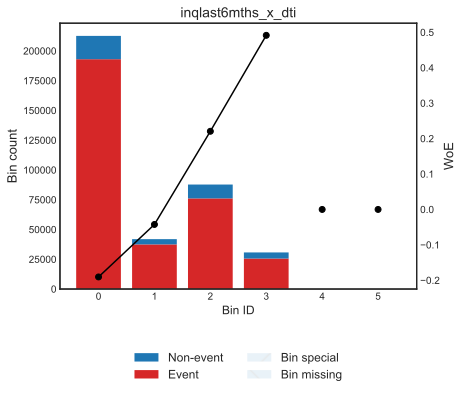

In [90]:
wt_adebt, bt_adebt, optb_adebt = get_woe_iv_optb(loan_Xt, 'inqlast6mths_x_dti', loan_yt, plot = True, 
                                                 prebinning_method = 'cart', monotonic_trend = 'descending',max_n_bins = 4)

In [91]:
wt_adebt

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Ref_Bin
0,"(-inf, 8.99)",212635,0.570024,19583,193052,0.907903,0.190553,0.019210,0.002398,False
1,"[8.99, 17.04)",41897,0.112316,4410,37487,0.894742,0.042375,0.000198,0.000025,False
2,"[17.04, 45.13)",87765,0.235277,11649,76116,0.867271,-0.220707,0.012487,0.001558,False
3,"[45.13, inf)",30731,0.082383,5136,25595,0.832872,-0.491623,0.024048,0.002976,True
4,Special,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
5,Missing,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
Totals,,373028,1.000000,40778,332250,0.890684,,0.055942,0.006956,False


In [92]:
bt_adebt.analysis(print_output = 0)

bt_adebt.quality_score

0.1662267672907028

- `loan_amnt` / `annual_inc` : Recall that we have not utilized `loan_amnt` as a predictor as it had quite a low `IV` but we can use another effective proxy for it by considering the ratio between the loan amount applied by the borrower and annual income. 

In [93]:
loan_Xt['loan_to_income'] = loan_Xt['loan_amnt'] / loan_Xt['annual_inc']
loan_Xval['loan_to_income'] = loan_Xval['loan_amnt'] * loan_Xval['annual_inc']

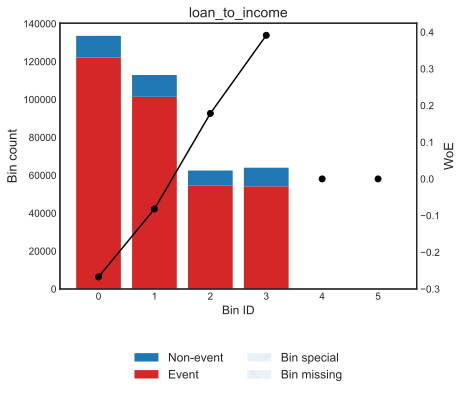

In [94]:
wt_lti, bt_lti, optb_lti = get_woe_iv_optb(loan_Xt, 'loan_to_income', loan_yt, plot = True, 
                                              prebinning_method = 'cart',
                                                 max_n_bins = 4)

In [95]:
wt_lti

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Ref_Bin
0,"(-inf, 0.16)",133578,0.358091,11473,122105,0.914110,0.26714,0.023016,0.002868,False
1,"[0.16, 0.26)",112922,0.302717,11471,101451,0.898417,0.082009,0.001972,0.000246,False
2,"[0.26, 0.33)",62524,0.167612,8000,54524,0.872049,-0.178546,0.005728,0.000715,False
3,"[0.33, inf)",64004,0.171580,9834,54170,0.846353,-0.391463,0.030581,0.003798,True
4,Special,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
5,Missing,0,0.000000,0,0,0.000000,-0.0,0.000000,0.000000,False
Totals,,373028,1.000000,40778,332250,0.890684,,0.061296,0.007628,False


In [96]:
bt_lti.analysis(print_output = 0)
bt_lti.quality_score

0.21879650668171996

In [97]:
# dummify the new interaction 'inqlast6mths_x_dti'

var = 'inqlast6mths_x_dti'
bounds_list = wt_adebt.loc[:3, 'Bin'].apply(extract_numbers).to_list()

for bound in bounds_list:
    
    if bound[0] == 'inf':
            
        loan_Xt_pp.loc[:,f"{var}:<{bound[1]}"] = np.where(loan_Xt[var] < float(bound[1]), True, False)
        loan_Xval_pp.loc[:,f"{var}:<{bound[1]}"] = np.where(loan_Xval[var] < float(bound[1]), True, False)
            
    elif bound[1] == 'inf':
            
        loan_Xt_pp.loc[:,f"{var}:>{bound[0]}"] = np.where(loan_Xt[var] > float(bound[0]), True, False)
        loan_Xval_pp.loc[:,f"{var}:>{bound[0]}"] = np.where(loan_Xval[var] > float(bound[0]), True, False)
            
    else:
            
        loan_Xt_pp.loc[:,f"{var}:{bound[0]}-{bound[1]}"] = np.where((loan_Xt[var] >= float(bound[0])) & (loan_Xt[var] < float(bound[1])), True, False)
        loan_Xval_pp.loc[:,f"{var}:{bound[0]}-{bound[1]}"] = np.where((loan_Xval[var] >= float(bound[0])) & (loan_Xval[var] < float(bound[1])), True, False)

In [98]:
# dummify 'loan_to_income'

var = 'loan_to_income'
bounds_list = wt_lti.loc[:3, 'Bin'].apply(extract_numbers).to_list()

for bound in bounds_list:
    
    if bound[0] == 'inf':
            
        loan_Xt_pp.loc[:,f"{var}:<{bound[1]}"] = np.where(loan_Xt[var] < float(bound[1]), True, False)
        loan_Xval_pp.loc[:,f"{var}:<{bound[1]}"] = np.where(loan_Xval[var] < float(bound[1]), True, False)
            
    elif bound[1] == 'inf':
            
        loan_Xt_pp.loc[:,f"{var}:>{bound[0]}"] = np.where(loan_Xt[var] > float(bound[0]), True, False)
        loan_Xval_pp.loc[:,f"{var}:>{bound[0]}"] = np.where(loan_Xval[var] > float(bound[0]), True, False)
            
    else:
            
        loan_Xt_pp.loc[:,f"{var}:{bound[0]}-{bound[1]}"] = np.where((loan_Xt[var] >= float(bound[0])) & (loan_Xt[var] < float(bound[1])), True, False)
        loan_Xval_pp.loc[:,f"{var}:{bound[0]}-{bound[1]}"] = np.where((loan_Xval[var] >= float(bound[0])) & (loan_Xval[var] < float(bound[1])), True, False)

In [100]:
# add reference bins for the last interaction variables
ref_bins_df = pd.concat([ref_bins_df, pd.DataFrame({'Variable': ['inqlast6mths_x_dti', 'loan_to_income'],
                                                     'Opt_Ref_Bin': [wt_adebt['Bin'][wt_adebt['Ref_Bin'] == True].values[0],
                                                                     wt_lti['Bin'][wt_lti['Ref_Bin'] == True].values[0]]})], axis = 0)

In [102]:
ref_bins_df = ref_bins_df.reset_index(drop=True)
ref_bins_df

,Variable,Opt_Ref_Bin
0,home_ownership,"[OTHER, NONE, RENT]"
1,verification_status,[Verified]
2,purpose,"[small_business, educational, moving, house, other, renewable_energy, medical]"
3,addr_state,"[NE, IA, NV, FL, HI, AL]"
4,initial_list_status,[f]
5,inq_last_6mths,"[2.50, inf)"
6,emp_length_years,"(-inf, 0.50)"
7,term_in_months,"[48.00, inf)"
8,total_rev_hi_lim_missing,"[0.50, inf)"
9,tot_coll_amt_missing,"[0.50, inf)"


In [103]:
# Save the training/validation sets in a seperate local folder as csv.
# Save reference bins as well

model_data_dir = 'model_data/'

loan_Xt_pp.to_csv(model_data_dir + 'loan_data_train_pp.csv')
loan_Xval_pp.to_csv(model_data_dir + 'loan_data_val_pp.csv')

loan_yt.to_csv(model_data_dir + 'loan_data_target.csv')
loan_yval.to_csv(model_data_dir + 'loan_data_target_val.csv')

ref_bins_df.to_csv(model_data_dir + 'reference_bins.csv')